In [1]:
## MP 573 Lecture 29: SNR and CNR
##
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, Image
import matplotlib.image as mpimg
from os.path import dirname, join as pjoin
import scipy.io as sio
from scipy import signal
import pywt as wt
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, rescale
import scipy.stats as stats
import statsmodels.api as sm

font = {'weight' : 'normal',
        'size'   : 12}

np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

### Multi-repetition method for SNR measurement


In certain scenarios (particularly when imaging phantoms for the purpose of quality analysis), we may be able to repeat our acquisition multiple ($M$) times, in order to obtain $M$ images $S_{N,m}$, for $m=1,\ldots,M$, that are identical except for the noise. Under the assumption of additive zero-mean noise, we can estimate $S(\mathbf{r})$ at each location $\mathbf{r}$ as the sample mean of our $M$ images: 

$S_{est}(\mathbf{r}) = \frac{1}{M} \sum_{m=1}^M S_{N,m}(\mathbf{r})$ 

and $\sigma(\mathbf{r})$ as the (bias-corrected)  standard deviation of our $M$ images: 

$\sigma_{est}(\mathbf{r}) = \sqrt{ \frac{1}{M-1} \sum_{m=1}^M (S_{N,m}(\mathbf{r}) - S_{est}(\mathbf{r}))}$ 

Note that the denominator $M-1$ (instead of $M$ as would correspond to the sample standard deviation) is needed to avoid bias (underestimation) in the estimation of $\sigma$. An advantage of this method allows calculation of SNR at each pixel without additional assumptions about spatial homogeneity of $S(\mathbf{r})$ or $\sigma(\mathbf{r})$. A disadvantage of this method is that it requires acquisition of multiple repetitions (often $M>10$), which requires longer scan times and also places strict requirements on system stability and lack of motion.

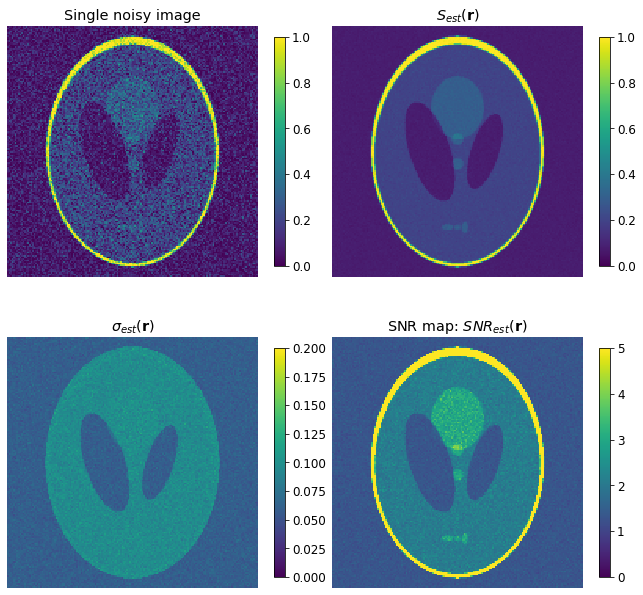

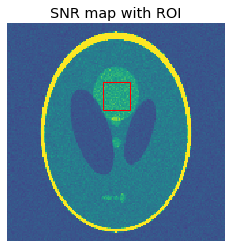

Multi-repetition: SNR in ROI: 
3.005019645936176


In [2]:
# Simulate noiseless image
Stemp = shepp_logan_phantom()
Stemp = rescale(Stemp, scale=0.4)
size1,size2 = Stemp.shape
S = np.zeros((size1,size2,1))
S[:,:,0] = Stemp

# Add iid Gaussian noise
std = 0.1
Nr = 100
x = np.random.normal(0,std,[size1,size2,Nr])
Sn = np.abs(np.repeat(S, Nr, axis=2) + x)

# Calculate the mean of the noisy signal across repetitions
Sest = np.mean(Sn,2) # Note this is the same as the mean of (S + N) since S is deterministic

# Calculate the standard deviation of noise across repetitions
sigma_est = np.sqrt(1/(Nr-1)*np.sum((Sn - np.repeat(Sest[:,:,None], Nr, axis=2))**2,2))

# Calculate the SNR map
SNRmap = Sest/sigma_est

# Display
plt.figure(figsize=(9,9))
plt.rc('font', **font)
plt.subplot(2,2,1)
plt.imshow(Sn[:,:,0],vmin=0,vmax=1,extent = [-1,1,-1,1])
plt.title('Single noisy image')
plt.colorbar(shrink=0.7);
plt.xlabel('$r_1$');plt.ylabel('$r_2$');
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(Sest,vmin=0,vmax=1,extent = [-1,1,-1,1])
plt.title('$S_{est}(\mathbf{r})$')
plt.colorbar(shrink=0.7);
plt.xlabel('$r_1$');plt.ylabel('$r_2$');
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(sigma_est,vmin=0,vmax=0.2,extent = [-1,1,-1,1]);
plt.title('$\sigma_{est}(\mathbf{r})$')
plt.colorbar(shrink=0.7);
plt.xlabel('$r_1$');plt.ylabel('$r_2$');
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(SNRmap,vmin=0,vmax=5,extent = [-1,1,-1,1]);
plt.title('SNR map: $SNR_{est}(\mathbf{r})$')
plt.colorbar(shrink=0.7);
plt.xlabel('$r_1$');plt.ylabel('$r_2$');
plt.axis('off')
plt.tight_layout(pad=0.4)

# Average over a square region-of-interest within the circle, in the SNR map
SNR_multirep = np.mean(SNRmap[43:62, 70:89])


# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(SNRmap,vmin=0,vmax=5)
ax.set_title('SNR map with ROI')
# Create a Rectangle patch
rectS = patches.Rectangle((70, 43), 20, 20, linewidth=1, edgecolor='r', facecolor='none')
#rectN = patches.Rectangle((120, 5), 30, 20, linewidth=1, edgecolor='w', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rectS)
#ax.add_patch(rectN)
plt.axis('off')
plt.show()

print('Multi-repetition: SNR in ROI: ')
print(SNR_multirep)


### Acquisition of two repetitions:

A simplified version of the multi-repetition method described above consists of acquiring only two repetitions, $S_{N,1}$ and $S_{N,2}$, from which estimates of signal and noise can be calculated. Note that, in principle, one might apply the multi-repetition method described above to a two-repetition acquisition. However, the pixel-by-pixel estimates of signal and noise are likely to be noisy themselves, and so this approach is rarely used. Instead, a more common approach is to obtain the sum image 

$S_{+} = S_{N,1} + S_{N,2}$ 

and the difference image 

$S_{-} = S_{N,1} - S_{N,2}$

Importantly, this difference image can be attributed purely to noise (since the true noiseless signal should cancel out). Based on these images $S_{+}$ and $S_{-}$, one can find a region of relative signal homogeneity in $S_{+}$ located within a tissue of interest, and draw an identical region-of-interest in both $S_{+}$ and $S_{-}$. From this region of interest, one can extract the mean of the pixel values in $S_{+}$, which can be attributed largely to true signal (and should approximate $2 S$), and the the standard deviation of the pixel values in $S_{-}$, which can be attributed to noise (and should approximate $\sqrt{2} \sigma$). From these measurements, one can estimate SNR (over an ROI) as follows: 

$\hbox{SNR}_{est} = \frac{\hbox{mean}_{ROI} (S_{+})}{\sqrt{2} \hbox{stdev}_{ROI} (S_{-})} \approx \frac{2 S}{\sqrt{2} \sqrt{2} \sigma}$ 

This approach enables calculation of SNR over an ROI with only two repeated acquisitions, and with only mild assumptions about homogeneity of the signal and the noise properties over the ROI. Compared to the multi-repetition method described above, the two-repetition method can be acquired relatively rapidly and is less sensitive to motion artifacts and other instabilities, although it does not provide pixel-by-pixel maps of SNR. However, this method still requires the acquisition of two repeated images, so it may not always be practical. Next we review an even simpler method based on stronger assumptions. 

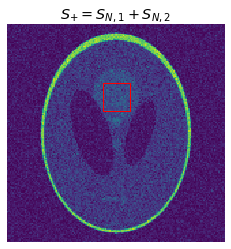

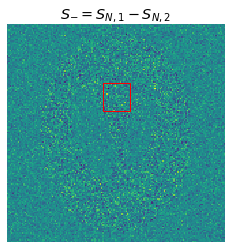

Two-repetition: mean(Splus) in ROI: 
0.5958792201217883
Two-repetition: std(Sminus) in ROI: 
0.14427770631583758
Two-repetition: SNR in ROI: 
2.920411254625107


In [3]:
# Two-repetition method
Splus = Sn[:,:,0] + Sn[:,:,1]
Sminus = Sn[:,:,0] - Sn[:,:,1]


# Display
# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(Splus)
ax.set_title('$S_{+} = S_{N,1} + S_{N,2}$')
# Create a Rectangle patch
rectS = patches.Rectangle((70, 43), 20, 20, linewidth=1, edgecolor='r', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rectS)
plt.axis('off')
plt.show()



# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(Sminus)
ax.set_title('$S_{-} = S_{N,1} - S_{N,2}$')
# Create a Rectangle patch
# rectN = patches.Rectangle((120, 5), 30, 20, linewidth=1, edgecolor='w', facecolor='none')
rectS = patches.Rectangle((70, 43), 20, 20, linewidth=1, edgecolor='r', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rectS)
plt.axis('off')
plt.show()

Splus_ROI = np.mean(Splus[43:62, 70:89])
Sminus_ROI = np.sqrt(np.var(Sminus[43:62, 70:89])) # Biased by Npixels/(Npixels-1)

SNR_2rep = Splus_ROI/(np.sqrt(2)*Sminus_ROI)

print('Two-repetition: mean(Splus) in ROI: ')
print(Splus_ROI)

print('Two-repetition: std(Sminus) in ROI: ')
print(Sminus_ROI)

print('Two-repetition: SNR in ROI: ')
print(SNR_2rep)




## Two-ROI method (signal and background): 

From a single noisy image, one may be able to estimate SNR under several key assumptions: i) ability to identify a relatively homogeneous signal region in a tissue of interest, ii) homogeneity of noise properties throughout the entire image (particularly homogeneity of $\sigma$, which is independent of $\mathbf{r}$),  and iii) ability to identify a background region with zero true signal (noise-only background region). Based on these assumptions, one can draw an ROI in the signal region, another ROI in the background noise region, and estimate SNR as follows:
    
$\hbox{SNR}_{est}  = \frac{\hbox{mean}_{\hbox{ROI,signal}} (S_N)}{ \hbox{stdev}_{\hbox{ROI,noise}} (S_{N})} \approx \frac{S}{\sigma}$
        
In practice, however, images may have an additional complication: even assuming Gaussian i.i.d. in the original image, the image that is actually presented by the imaging device is typically rectified (i.e., a magnitude operation has been performed). In this case, the assumption of Gaussian noise in the signal region is still typically accurate, but the assumption of Gaussian noise in the (magnitude-rectified) noise-only region is not accurate. Instead, the background noise-only region has a Rayleigh distribution with reduced standard deviation by a factor $\approx 1.53$, which needs to be compensated as follows:

$\hbox{SNR}_{est}  = \frac{\hbox{mean}_{\hbox{ROI,signal}} (S_N)}{ 1.53 \hbox{stdev}_{\hbox{ROI,noise}} (S_{N})} \approx \frac{S}{\sigma}$
    
This two-ROI method is widely used in practice, but needs to be approached with caution as the assumption of spatially homogeneous noise distribution (even accounting for the Rayleigh distribution) is a strong assumption that is far from accurate in many cases. 

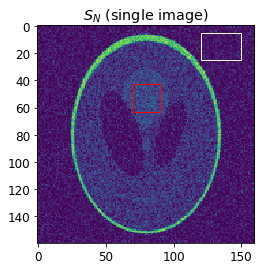

Two-repetition: mean(Splus) in ROI: 
0.2974897890853207
Standard deviation of noise in background ROI: 
0.05796753102390731
Two-repetition: SNR in ROI: 
3.3542531001330604


In [4]:
# Two-repetition method
Sn1 = Sn[:,:,0]


# Display
# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(Sn1)
ax.set_title('$S_N$ (single image)')
# Create a Rectangle patch
rectS = patches.Rectangle((70, 43), 20, 20, linewidth=1, edgecolor='r', facecolor='none')
rectN = patches.Rectangle((120, 5), 30, 20, linewidth=1, edgecolor='w', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rectS)
ax.add_patch(rectN)
plt.show()

Smean = np.mean(Sn1[43:62, 70:89])
Nsigma = np.sqrt(np.var(Sn1[5:24, 120:149])) # Biased by Npixels/(Npixels-1)

SNR_1rep = Smean/(1.53*Nsigma)

print('Two-repetition: mean(Splus) in ROI: ')
print(Smean)

print('Standard deviation of noise in background ROI: ')
print(Nsigma)

print('Two-repetition: SNR in ROI: ')
print(SNR_1rep)



